## Import Modules

In [2]:
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from datetime import datetime
from scipy.optimize import minimize

## Define Functions

In [3]:
from typing import Iterable 
#from collections imtmp Iterable                            # < py38


def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

## Import Data

In [4]:
df_price = pd.read_excel("Price.xlsx", index_col=0) 
df_price.index = df_price.index.to_series().dt.to_period('M')
df_price

,Mnemonic,Close
Date,,
2019-12,4SI:XJSE:EQU,32.0
2019-11,4SI:XJSE:EQU,20.0
2019-10,4SI:XJSE:EQU,20.0
2019-09,4SI:XJSE:EQU,20.0
2019-08,4SI:XJSE:EQU,18.0
...,...,...
2009-05,ZED:XJSE:EQU,144.0
2009-04,ZED:XJSE:EQU,148.0
2009-03,ZED:XJSE:EQU,140.0


In [5]:
df_size = pd.read_excel("Market Capitalizations.xlsx", usecols=[0,2,3], index_col=1)
df_size.index = df_size.index.to_series().dt.to_period('M')
df_size

,Mnemonic,Market Cap
Date,,
2019-12,4SI:XJSE:EQU,253217582.0
2019-11,4SI:XJSE:EQU,158260989.0
2019-10,4SI:XJSE:EQU,158260989.0
2019-09,4SI:XJSE:EQU,158260989.0
2019-08,4SI:XJSE:EQU,142434890.0
...,...,...
2009-05,ZED:XJSE:EQU,880279665.0
2009-04,ZED:XJSE:EQU,904687478.0
2009-03,ZED:XJSE:EQU,855785452.0


In [6]:
df_MR = pd.read_excel("J203T Price.xlsx", usecols=[0,1], index_col=0)
df_MR

,J203T
Dates,
2000-01-04,694.664
2000-01-05,687.378
2000-01-06,688.400
2000-01-07,705.859
2000-01-10,729.218
...,...
2020-02-24,8332.211
2020-02-25,8321.271
2020-02-26,8357.358


In [7]:
df_RF = pd.read_excel("91days T-Bill rate.xlsx", index_col=0)
df_RF


,Value
Date,
2000-01-05,10.71
2000-01-06,10.71
2000-01-07,10.56
2000-01-10,10.56
2000-01-11,10.56
...,...
2019-12-25,7.19
2019-12-26,7.19
2019-12-27,7.16


## Sorting Data

Reform price data frame

In [8]:
tmp = pd.DataFrame()
labels = []
n = int((2019-2009+1)*12)

for i in range(int(len(df_price)/n)): 
    price = pd.DataFrame(df_price.iloc[(n*(i-1)):(n*i),1])
    name = df_price.iloc[range(1,len(df_price),n)[i],0]
    tmp = pd.concat([tmp,price], axis=1)
    labels.append(name)
    tmp.columns = [labels]


In [9]:
df_price = tmp
# reorder the date of price data
df_price = df_price.sort_index(ascending=True)
df_price.columns = df_price.columns.get_level_values(0).values
df_price

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-01,NaN,NaN,9300.0,NaN,NaN,4000.0,2290.0,NaN,370.0,5099.0,...,NaN,905.0,1750.0,116.0,64.0,9718.0,1345.0,32.0,NaN,1600.0
2009-02,NaN,NaN,8900.0,NaN,NaN,3826.0,2050.0,NaN,350.0,4399.0,...,NaN,825.0,850.0,108.0,40.0,8500.0,1190.0,25.0,NaN,1150.0
2009-03,NaN,NaN,9620.0,NaN,NaN,3600.0,1700.0,NaN,371.0,4400.0,...,NaN,919.0,1500.0,120.0,54.0,8509.0,1140.0,18.0,NaN,540.0
2009-04,NaN,NaN,9845.0,NaN,NaN,4200.0,2100.0,NaN,400.0,4875.0,...,NaN,930.0,750.0,134.0,70.0,10001.0,1200.0,18.0,NaN,540.0
2009-05,NaN,NaN,10155.0,NaN,NaN,4200.0,2300.0,NaN,415.0,4600.0,...,5200.0,960.0,600.0,170.0,55.0,10355.0,1250.0,22.0,NaN,460.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,NaN,18.0,15369.0,295.0,725.0,5775.0,2000.0,45.0,1109.0,9099.0,...,11529.0,1872.0,255.0,40.0,3.0,10018.0,5518.0,140.0,1800.0,170.0
2019-09,NaN,20.0,15287.0,174.0,725.0,5675.0,2055.0,38.0,1250.0,9596.0,...,11964.0,1900.0,255.0,52.0,3.0,14290.0,5508.0,160.0,1840.0,160.0
2019-10,NaN,20.0,15488.0,198.0,600.0,5624.0,1370.0,42.0,1125.0,9765.0,...,13185.0,1934.0,250.0,55.0,3.0,14118.0,5749.0,160.0,1865.0,160.0


Reform size data frame

In [10]:
tmp = pd.DataFrame()

for i in range(int(len(df_size)/n)): 
    size = pd.DataFrame(df_size.iloc[(n*(i-1)):(n*i),1])
    tmp = pd.concat([tmp,size], axis=1)
tmp.columns = flatten([labels])

In [11]:
df_size = tmp
# reorder the date of size data
df_size = df_size.sort_index(ascending=True)
df_size

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-01,NaN,NaN,6.326588e+10,NaN,NaN,6.916287e+09,1.238633e+09,NaN,1.456560e+09,6.060008e+09,...,NaN,2.674735e+09,431987500.0,679168221.0,117095434.0,6.413880e+09,1.074192e+10,76800000.0,NaN,1.253921e+09
2009-02,NaN,NaN,6.054477e+10,NaN,NaN,6.615428e+09,1.111497e+09,NaN,1.377827e+09,5.228079e+09,...,NaN,2.438295e+09,209822500.0,632329033.0,73184646.0,5.610000e+09,9.504005e+09,60000000.0,NaN,9.012558e+08
2009-03,NaN,NaN,6.545181e+10,NaN,NaN,6.224658e+09,9.217295e+08,NaN,1.460497e+09,5.229267e+09,...,NaN,2.716113e+09,370275000.0,702587815.0,98799273.0,5.615940e+09,9.112693e+09,43200000.0,NaN,4.231984e+08
2009-04,NaN,NaN,6.698264e+10,NaN,NaN,7.262101e+09,1.138607e+09,NaN,1.574660e+09,5.793791e+09,...,NaN,2.748623e+09,185137500.0,784556393.0,128073131.0,6.600660e+09,9.592308e+09,43200000.0,NaN,4.231984e+08
2009-05,NaN,NaN,6.909180e+10,NaN,NaN,7.262101e+09,1.247046e+09,NaN,1.633709e+09,5.466961e+09,...,7.737361e+10,2.837288e+09,148110000.0,995332738.0,100903889.0,6.834300e+09,9.991988e+09,52800000.0,NaN,3.605023e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,NaN,142434890.0,1.302908e+11,2.945648e+09,2.863460e+09,1.015007e+10,2.199094e+09,129594794.0,6.061937e+09,1.108523e+10,...,2.116569e+11,1.790056e+10,410947583.0,651130823.0,8291796.0,5.999832e+09,5.785436e+10,341223880.0,9.524873e+08,5.631090e+08
2019-09,NaN,158260989.0,1.295956e+11,1.737433e+09,2.863460e+09,9.974315e+09,2.259569e+09,109435604.0,6.832661e+09,1.169072e+10,...,2.196429e+11,1.816831e+10,410947583.0,846470070.0,8291796.0,8.558354e+09,5.774957e+10,389970148.0,9.736537e+08,5.299850e+08
2019-10,NaN,158260989.0,1.312996e+11,1.977079e+09,2.369760e+09,9.884678e+09,1.506379e+09,120955141.0,6.149395e+09,1.189661e+10,...,2.420588e+11,1.849342e+10,402889787.0,895304881.0,8291796.0,8.455343e+09,6.027737e+10,389970148.0,9.868827e+08,5.299850e+08


Calculate stock returns

In [12]:
# np.log(1 + df_price.pct_change()) #or below
df_SR = np.log(df_price/df_price.shift(1)) # formula = ln(Pt/Pt-1)
df_SR = df_SR.iloc[1:,:]
df_SR.replace([np.inf, -np.inf], np.nan, inplace=True) # replace the inf number to NA as ln(0) will return inf
# np.isinf(df_SR).sum().sum() # test whether infs are replaced 
df_SR

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-02,NaN,NaN,-0.043963,NaN,NaN,-0.044474,-0.110712,NaN,-0.055570,-0.147667,...,NaN,-0.092552,-0.722135,-0.071459,-0.470004,-0.133914,-0.122441,-0.246860,NaN,-0.330242
2009-03,NaN,NaN,0.077793,NaN,NaN,-0.060886,-0.187212,NaN,0.058269,0.000227,...,NaN,0.107903,0.567984,0.105361,0.300105,0.001058,-0.042925,-0.328504,NaN,-0.755948
2009-04,NaN,NaN,0.023119,NaN,NaN,0.154151,0.211309,NaN,0.075262,0.102516,...,NaN,0.011898,-0.693147,0.110348,0.259511,0.161561,0.051293,0.000000,NaN,0.000000
2009-05,NaN,NaN,0.031002,NaN,NaN,0.000000,0.090972,NaN,0.036814,-0.058064,...,NaN,0.031749,-0.223144,0.237959,-0.241162,0.034784,0.040822,0.200671,NaN,-0.160343
2009-06,NaN,NaN,0.079929,NaN,NaN,0.015123,0.042560,NaN,0.035507,0.010811,...,0.095310,-0.121697,-0.182322,0.344840,-0.178692,0.025270,0.035367,0.127833,NaN,-0.044452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,NaN,0.000000,-0.038234,0.000000,0.189242,0.006079,-0.159138,-0.200671,-0.131613,-0.021850,...,-0.020348,-0.008511,0.060625,0.025318,0.000000,-0.140656,0.003267,-0.035091,0.045462,0.000000
2019-09,NaN,0.105361,-0.005350,-0.527920,0.000000,-0.017468,0.027129,-0.169076,0.119685,0.053182,...,0.037037,0.014847,0.000000,0.262364,0.000000,0.355177,-0.001814,0.133531,0.021979,-0.060625
2019-10,NaN,0.000000,0.013063,0.129212,-0.189242,-0.009027,-0.405465,0.100083,-0.105361,0.017458,...,0.097178,0.017737,-0.019803,0.056089,0.000000,-0.012109,0.042824,0.000000,0.013495,0.000000


Calculate risk-free and market returns

In [13]:
df_RF = (1+df_RF['Value'].astype(np.float64)/100)**(1/365)-1
df_RF.index = pd.to_datetime(df_RF.index)
df_RF = pd.DataFrame(df_RF.resample('M').sum())
df_RF.index = df_RF.index.to_series().dt.to_period('M')
df_RF = df_RF.loc[df_SR.index,:]
df_RF

,Value
Date,
2009-02,0.004854
2009-03,0.004984
2009-04,0.004798
2009-05,0.004276
2009-06,0.004203
...,...
2019-08,0.004076
2019-09,0.003813
2019-10,0.004153


In [14]:
tmp = np.log(df_MR/df_MR.shift(1))
df_MR = tmp.iloc[1:,:]
df_MR.index = pd.to_datetime(df_MR.index)
df_MR = pd.DataFrame(df_MR.resample('M',convention='end').sum())
df_MR.index = df_MR.index.to_series().dt.to_period('M')
df_MR = df_MR.loc[df_SR.index,:]
df_MR

,J203T
Date,
2009-02,-0.103955
2009-03,0.104531
2009-04,0.015669
2009-05,0.098319
2009-06,-0.031028
...,...
2019-08,-0.024655
2019-09,0.001913
2019-10,0.030952


In [15]:
df_size = df_size.loc[df_SR.index,:]

Calculate stock excess returns

In [16]:
df_Ex_SR = df_SR.apply(lambda x: x-df_RF.iloc[:,0], axis=0)
df_Ex_SR

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-02,NaN,NaN,-0.048818,NaN,NaN,-0.049329,-0.115567,NaN,-0.060424,-0.152522,...,NaN,-0.097406,-0.726989,-0.076313,-0.474858,-0.138768,-0.127295,-0.251715,NaN,-0.335096
2009-03,NaN,NaN,0.072809,NaN,NaN,-0.065870,-0.192196,NaN,0.053285,-0.004757,...,NaN,0.102918,0.563000,0.100376,0.295120,-0.003926,-0.047909,-0.333488,NaN,-0.760932
2009-04,NaN,NaN,0.018321,NaN,NaN,0.149353,0.206511,NaN,0.070464,0.097717,...,NaN,0.007100,-0.697945,0.105550,0.254713,0.156763,0.046495,-0.004798,NaN,-0.004798
2009-05,NaN,NaN,0.026726,NaN,NaN,-0.004276,0.086696,NaN,0.032538,-0.062340,...,NaN,0.027473,-0.227420,0.233683,-0.245438,0.030508,0.036546,0.196395,NaN,-0.164619
2009-06,NaN,NaN,0.075726,NaN,NaN,0.010920,0.038356,NaN,0.031303,0.006608,...,0.091107,-0.125900,-0.186525,0.340637,-0.182895,0.021066,0.031164,0.123630,NaN,-0.048655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,NaN,-0.004076,-0.042310,-0.004076,0.185166,0.002003,-0.163214,-0.204746,-0.135689,-0.025925,...,-0.024424,-0.012586,0.056549,0.021242,-0.004076,-0.144731,-0.000808,-0.039167,0.041387,-0.004076
2019-09,NaN,0.101547,-0.009163,-0.531733,-0.003813,-0.021281,0.023315,-0.172890,0.115872,0.049368,...,0.033223,0.011033,-0.003813,0.258551,-0.003813,0.351363,-0.005627,0.129718,0.018166,-0.064438
2019-10,NaN,-0.004153,0.008910,0.125059,-0.193395,-0.013180,-0.409618,0.095931,-0.109513,0.013305,...,0.093025,0.013584,-0.023955,0.051937,-0.004153,-0.016262,0.038672,-0.004153,0.009343,-0.004153


## CAPM Regression (Time-Varying Betas)

We use a rolling window of 36 month to estimate market betas, and these betas are updated monthly.

In [17]:
holding = 1 # Define the update frequency
rollingW = 36 # Define the length of lookback estimation window
lens = len(df_Ex_SR)
periods = int((lens - rollingW) / holding) # Calculate the holding periods
print(periods,rollingW)

95 36


In [18]:
all_betas = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR.iloc[i*holding:i*holding+rollingW,:]

    betas = []
    labels = []
    for j in df_Ex_SR.columns:
        # drop the NA returns and only keep the date that have valid returns
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        if len(df_index) >= 2: # We can only draw a line based on two points or above
            ols = sm.OLS(df_Ex_SR_tmp.loc[df_index,j].values.astype(np.float64), 
            sm.add_constant(df_MR_tmp.loc[df_index,:].values.astype(np.float64)))
            res = ols.fit()
            b = res.params[1] # Only betas
            betas.append(b)
            labels.append(j)

    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'Beta'})
    df_betas.index = labels
    all_betas.append(df_betas)

100%|██████████| 95/95 [00:12<00:00,  7.37it/s]


In [19]:
k = np.random.randint(0,periods-1)
print(k)
all_betas[k]

78


,Beta
ABG:XJSE:EQU,-0.406805
APF:XJSE:EQU,0.552468
ACS:XJSE:EQU,0.360466
AIP:XJSE:EQU,-0.413505
ADR:XJSE:EQU,0.312824
...,...
WHL:XJSE:EQU,0.391354
WKF:XJSE:EQU,0.800593
YYLBEE:XJSE:EQU,0.215140
YRK:XJSE:EQU,-0.124121


Ranking betas

In [20]:
print(k)
all_betas[k].sort_values(by="Beta")

78


,Beta
BWN:XJSE:EQU,-7.782995
LHC:XJSE:EQU,-5.287897
BYI:XJSE:EQU,-3.421434
KIO:XJSE:EQU,-3.101633
VOD:XJSE:EQU,-2.747713
...,...
NT1:XJSE:EQU,2.636857
EXP:XJSE:EQU,2.675197
OAO:XJSE:EQU,2.780866
DRA:XJSE:EQU,4.623002


## Ranking Betas

In [21]:
Ranks = []

for i in tqdm(range(periods)):
    rank_betas = all_betas[i].sort_values(by="Beta")
    number_of_portfolios = 5
    N = len(rank_betas)
    quantile = int(N/number_of_portfolios)
    ranks = {"Low_Beta":rank_betas.index[0:quantile],
            "P1":rank_betas.index[(quantile+1):(2*quantile)],
            "P2":rank_betas.index[(2*quantile+1):(3*quantile)],
            "P3":rank_betas.index[(3*quantile+1):(N-quantile)],
            "High_Beta":rank_betas.index[(N-quantile+1):N]}
    Ranks.append(ranks)


100%|██████████| 95/95 [00:00<00:00, 7387.76it/s]


In [22]:
print(k)
Ranks[k]

78


{'Low_Beta': Index(['BWN:XJSE:EQU', 'LHC:XJSE:EQU', 'BYI:XJSE:EQU', 'KIO:XJSE:EQU',
        'VOD:XJSE:EQU', 'PPH:XJSE:EQU', 'GML:XJSE:EQU', 'AFH:XJSE:EQU',
        'LUX:XJSE:EQU', 'KAP:XJSE:EQU', 'PPE:XJSE:EQU', 'LEW:XJSE:EQU',
        'NTC:XJSE:EQU', 'SOH:XJSE:EQU', 'HWA:XJSE:EQU', 'ITE:XJSE:EQU',
        'RBX:XJSE:EQU', 'FSE:XJSE:EQU', 'MTU:XJSE:EQU', 'QFH:XJSE:EQU',
        'EMH:XJSE:EQU', 'CMH:XJSE:EQU', 'TCP:XJSE:EQU', 'WBO:XJSE:EQU',
        'TRL:XJSE:EQU', 'AIP:XJSE:EQU', 'ABG:XJSE:EQU', 'S32:XJSE:EQU',
        'MLI:XJSE:EQU', 'AEL:XJSE:EQU', 'NY1:XJSE:EQU', 'AME:XJSE:EQU',
        'EEL:XJSE:EQU', 'AVL:XJSE:EQU', 'FBR:XJSE:EQU', 'NRL:XJSE:EQU',
        'AIL:XJSE:EQU', 'EUZ:XJSE:EQU', 'ACL:XJSE:EQU', 'FGL:XJSE:EQU',
        'TPC:XJSE:EQU', 'BTI:XJSE:EQU', 'KP2:XJSE:EQU', 'LBR:XJSE:EQU',
        'CCO:XJSE:EQU', 'SEP:XJSE:EQU', 'HLM:XJSE:EQU', 'GFI:XJSE:EQU',
        'IMP:XJSE:EQU', 'EOH:XJSE:EQU', 'PEM:XJSE:EQU', 'OCE:XJSE:EQU',
        'CRP:XJSE:EQU', 'ETO:XJSE:EQU', 'YRK:XJSE:EQ

## Portfolio Optimization

Define variance-covariance matrix estimation window is 36 months, which is the same as the beta estimation window

In [23]:
lookback_return_list = []
holding_return_list = []

for i in tqdm(range(periods)):
  lookback_return_list.append(df_SR.iloc[i*holding:i*holding+rollingW,:])
  holding_return_list.append(df_SR.iloc[i*holding+rollingW:(i+1)*holding+rollingW,:])


100%|██████████| 95/95 [00:00<00:00, 12536.07it/s]


In [24]:
# lookback_return_list[k]

In [25]:
lookback_size_list = []
holding_size_list = []

for i in tqdm(range(periods)):
  lookback_size_list.append(df_size.iloc[i*holding:i*holding+rollingW,:])
  holding_size_list.append(df_size.iloc[i*holding+rollingW:(i+1)*holding+rollingW,:])

100%|██████████| 95/95 [00:00<00:00, 13096.43it/s]


In [26]:
# lookback_size_list[k]

### 1. The naive equally-weighted portfolio of all stocks (EW)

In [27]:
def hld_period_calcs(a):
    port = a
    port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64)
    port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64)
    starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
    level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
    return returns

In [28]:
EW = list(map(hld_period_calcs, holding_return_list))

In [29]:
df_portfolio = pd.DataFrame()
df_portfolio["MR_RF"] = np.round((df_MR-df_RF.values)[rollingW:][0:periods*holding+1],4)
df_portfolio["EW"] = np.concatenate(EW)

In [30]:
df_portfolio

,MR_RF,EW
Date,,
2012-02,0.0137,0.0240
2012-03,-0.0175,-0.0020
2012-04,0.0248,0.0085
2012-05,-0.0400,-0.0378
2012-06,0.0152,0.0093
...,...,...
2019-08,-0.0287,-0.0504
2019-09,-0.0019,-0.0192
2019-10,0.0268,0.0092


### 2. Equal-Weighted lowbeta portfolio (EW)

Test

In [31]:
i = 0
index = holding_return_list[i].columns.intersection(Ranks[i]["Low_Beta"])
port = holding_return_list[i][index]
port = port.loc[:, (port != 0).any(axis=0)].astype(np.float64) # drop columns full of 0s
port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64) # drop columns full of nas
starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) #min_periods will keep the min_periods that is smaller than the window
value = pd.DataFrame(np.sum(level, axis=1).dropna())
returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
returns

array([[0.0433]])

Generalized the Process

In [32]:
def hld_period_calcs1(a,b):
    index = a.columns.intersection(b["Low_Beta"])
    port = a[index]
    port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64)
    port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64)
    starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
    level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
    return returns

In [33]:
Lowbeta = list(map(hld_period_calcs1, holding_return_list, Ranks))

In [34]:
df_portfolio["Lowbeta"] = np.concatenate(Lowbeta)
df_portfolio

,MR_RF,EW,Lowbeta
Date,,,
2012-02,0.0137,0.0240,0.0433
2012-03,-0.0175,-0.0020,-0.0064
2012-04,0.0248,0.0085,0.0170
2012-05,-0.0400,-0.0378,-0.0112
2012-06,0.0152,0.0093,-0.0008
...,...,...,...
2019-08,-0.0287,-0.0504,-0.0997
2019-09,-0.0019,-0.0192,-0.0552
2019-10,0.0268,0.0092,-0.0614


### 3. Market Capitalization-Weighted (MCW) 

In [35]:
i = 0
holding_return_list[i].columns.intersection(Ranks[i]["Low_Beta"]).intersection(holding_size_list[i].columns)

Index(['AVL:XJSE:EQU', 'AON:XJSE:EQU', 'AOVP:XJSE:EQU', 'ADW:XJSE:EQU',
       'AHL:XJSE:EQU', 'AFH:XJSE:EQU', 'BYI:XJSE:EQU', 'CGR:XJSE:EQU',
       'CML:XJSE:EQU', 'COH:XJSE:EQU', 'EMN:XJSE:EQU', 'ELI:XJSE:EQU',
       'EXP:XJSE:EQU', 'FSEO1:XJSE:DER', 'FTH:XJSE:EQU', 'HET:XJSE:EQU',
       'HLM:XJSE:EQU', 'IMP:XJSE:EQU', 'KP2:XJSE:EQU', 'LEW:XJSE:EQU',
       'L4L:XJSE:EQU', 'MSP:XJSE:EQU', 'MSM:XJSE:EQU', 'MIX:XJSE:EQU',
       'NY1:XJSE:EQU', 'OCE:XJSE:EQU', 'OMU:XJSE:EQU', 'ORN:XJSE:EQU',
       'PRX:XJSE:EQU', 'PPE:XJSE:EQU', 'REB:XJSE:EQU', 'RLO:XJSE:EQU',
       'RTO:XJSE:EQU', 'RFG:XJSE:EQU', 'SNV:XJSE:EQU', 'SEP:XJSE:EQU',
       'TKG:XJSE:EQU', 'TXT:XJSE:EQU', 'THA:XJSE:EQU', 'TDH:XJSE:EQU',
       'YYLBEE:XJSE:EQU', 'ZED:XJSE:EQU'],
      dtype='object')

In [36]:
mcap_wght = []

for i in range(periods):
    tmp = holding_size_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.loc[:,(tmp != 0).any(axis=0)].astype(np.float64)
    tmp = tmp.loc[:,(np.isnan(tmp)==False).any(axis=0)].astype(np.float64)
    wght = pd.DataFrame()
    wght = tmp/np.nansum(tmp)
    mcap_wght.append(wght)


In [37]:
mcap_wght[k]

,BWN:XJSE:EQU,LHC:XJSE:EQU,BYI:XJSE:EQU,KIO:XJSE:EQU,VOD:XJSE:EQU,PPH:XJSE:EQU,GML:XJSE:EQU,AFH:XJSE:EQU,LUX:XJSE:EQU,KAP:XJSE:EQU,...,IMP:XJSE:EQU,EOH:XJSE:EQU,PEM:XJSE:EQU,OCE:XJSE:EQU,CRP:XJSE:EQU,ETO:XJSE:EQU,YRK:XJSE:EQU,CSG:XJSE:EQU,SUR:XJSE:EQU,TFG:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2018-08,0.072911,0.046282,0.002501,0.00608,0.229167,0.000905,0.009626,0.000122,0.032876,0.020691,...,0.000195,0.016007,0.00165,0.00908,0.010333,0.044986,0.012556,0.005013,0.012831,0.031816


In [38]:
def hld_period_calcs2(a,b,weights):
    port = a[weights.columns]
    # port = a[b["Low_Beta"]]
    # port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64) #remove columns full of 0s
    # port = port.loc[:,(np.isnan(port)==False).any(axis=0)].astype(np.float64) #remove columns full of nas
    # index = port.columns.intersection(weights.columns)
    # port = port[index]
    # weights = weights[index]
    level = pd.concat([weights, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round((value[1:len(value)].values-value[0:len(value)-1].values)/value[0:len(value)-1].values,4)
    return returns

In [39]:
MCW = list(map(hld_period_calcs2,holding_return_list, Ranks, mcap_wght))

In [40]:
df_portfolio["MCW"] = np.concatenate(MCW)
df_portfolio

,MR_RF,EW,Lowbeta,MCW
Date,,,,
2012-02,0.0137,0.0240,0.0433,0.0300
2012-03,-0.0175,-0.0020,-0.0064,-0.0172
2012-04,0.0248,0.0085,0.0170,0.0071
2012-05,-0.0400,-0.0378,-0.0112,-0.0255
2012-06,0.0152,0.0093,-0.0008,0.0561
...,...,...,...,...
2019-08,-0.0287,-0.0504,-0.0997,-0.0536
2019-09,-0.0019,-0.0192,-0.0552,0.0005
2019-10,0.0268,0.0092,-0.0614,-0.0556


### 4. Minimum Variance Portfolio (MVP)

#### 4.1 Without any constrains

In [41]:
MVP_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.loc[:,(tmp != 0).any(axis=0)].astype(np.float64)
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64)
    cov_tmp = np.cov(tmp, rowvar=False) # Define which dimemsion represent variables; True for rows; False for columns
    inv_tmp = np.linalg.inv(cov_tmp)
    wght = pd.DataFrame(np.dot(np.ones(len(cov_tmp)),inv_tmp)/np.sum(inv_tmp), columns=["MVP_wght"], index=tmp.columns)
    MVP_wght.append(wght.T)

In [42]:
k = np.random.randint(0,periods-1)
print(k)
MVP_wght[k]

34


,FSR:XJSE:EQU,LEW:XJSE:EQU,AEE:XJSE:EQU,PRX:XJSE:EQU,MSM:XJSE:EQU,YYLBEE:XJSE:EQU,KP2:XJSE:EQU,OMU:XJSE:EQU,HLM:XJSE:EQU,MSP:XJSE:EQU,...,TDH:XJSE:EQU,ACT:XJSE:EQU,AME:XJSE:EQU,IMP:XJSE:EQU,SZK:XJSE:EQU,NUT:XJSE:EQU,BYI:XJSE:EQU,JSC:XJSE:EQU,ENX:XJSE:EQU,RDF:XJSE:EQU
MVP_wght,-0.060559,0.158731,0.362961,0.395175,0.799202,-0.760909,0.299439,-1.587565,-0.063256,-0.746146,...,-0.67378,-0.406209,-0.365753,-0.563671,-0.633418,-0.546731,-0.150474,2.083563,2.622014,1.574115


In [43]:
i = 24
a = holding_return_list[i]
b = Ranks[i]
weights = MVP_wght[i]
port = a[weights.columns]
# port = a[b["Low_Beta"]]
# port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64)
# port = port.loc[:,(np.isnan(port)==False).any(axis=0)].astype(np.float64)
# index = port.columns.intersection(weights.columns)
# port = port[index]
# weights = weights[index]
level = pd.concat([weights, port+1]).reset_index(drop=True)
level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
value = pd.DataFrame(np.sum(level, axis=1).dropna())
returns = np.round((value[1:len(value)].values-value[0:len(value)-1].values)/value[0:len(value)-1].values,4)
print(returns, weights.sum(axis=1).values)

[[0.2828]] [1.]


In [44]:
MVP = list(map(hld_period_calcs2,holding_return_list, Ranks, MVP_wght))

In [45]:
df_portfolio["MVP"] = np.concatenate(MVP)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVP
Date,,,,,
2012-02,0.0137,0.0240,0.0433,0.0300,0.0658
2012-03,-0.0175,-0.0020,-0.0064,-0.0172,0.0581
2012-04,0.0248,0.0085,0.0170,0.0071,0.0430
2012-05,-0.0400,-0.0378,-0.0112,-0.0255,-0.0410
2012-06,0.0152,0.0093,-0.0008,0.0561,-0.1000
...,...,...,...,...,...
2019-08,-0.0287,-0.0504,-0.0997,-0.0536,-0.9018
2019-09,-0.0019,-0.0192,-0.0552,0.0005,-0.5614
2019-10,0.0268,0.0092,-0.0614,-0.0556,0.2374


In [67]:
(df_portfolio+1).cumprod()

,MR_RF,EW,Lowbeta,MCW,MVP
Date,,,,,
2012-02,1.013700,1.024000,1.043300,1.030000,1.065800
2012-03,0.995960,1.021952,1.036623,1.012284,1.127723
2012-04,1.020660,1.030639,1.054245,1.019471,1.176215
2012-05,0.979834,0.991680,1.042438,0.993475,1.127990
2012-06,0.994727,1.000903,1.041604,1.049209,1.015191
...,...,...,...,...,...
2019-08,1.406749,0.698872,0.600196,1.294240,-1.263467
2019-09,1.404077,0.685454,0.567065,1.294888,-0.554157
2019-10,1.441706,0.691760,0.532248,1.222892,-0.685714


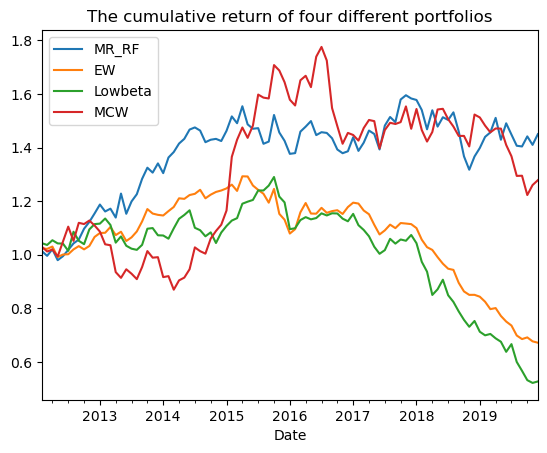

In [76]:
(df_portfolio.iloc[:,0:4]+1).cumprod().plot(title = "The cumulative return of four different portfolios")
plt.show()

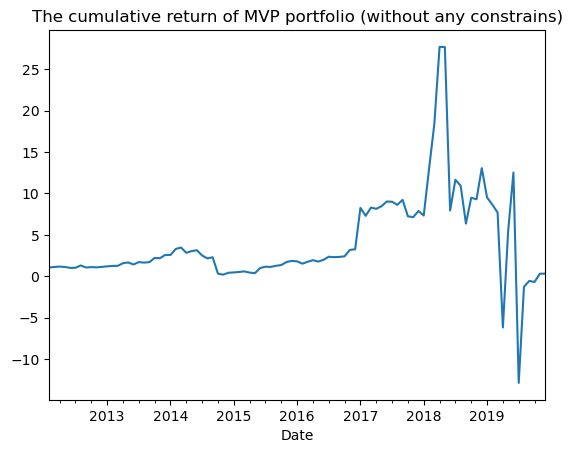

In [75]:
(df_portfolio.iloc[:,4]+1).cumprod().plot(title = "The cumulative return of MVP portfolio (without any constrains)")
plt.show()

In [77]:
df_portfolio.std()

MR_RF      0.031443
EW         0.023509
Lowbeta    0.033788
MCW        0.043644
MVP        0.533094
dtype: float64

The reason why MVP has so large standard deviation is because we did not add any constrain to its weights, thus its long and short weights can be unrealistic large

#### 4.2 With long-only constrains

In [ ]:
# the objective function is to minimize the portfolio risk
def objective(weights): 
    weights = np.array(weights)
    return weights.dot(returns.cov()).dot(weights.T)
 
# The constraints
cons = (# The weights must sum up to one.
        {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
        # This constraints says that the inequalities (ineq) must be non-negative.
        # The expected daily return of our portfolio and we want to be at greater than 0.003
        {"type": "ineq", "fun": lambda x: np.sum(returns.mean()*x)-0.003}) 
 
 
# Every stock can get any weight from 0 to 1
bounds = tuple((0,1) for x in range(returns.shape[1])) 
 
# Initialize the weights with an even split
# In out case each stock will have 10% at the beginning
guess = [1./returns.shape[1] for x in range(returns.shape[1])]
 
 
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
optimized_results